In [1]:
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
import math
from math import sqrt
import matplotlib.pylab as plt
from matplotlib import gridspec as gs
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import explained_variance_score, mean_absolute_error, median_absolute_error, mean_squared_error, r2_score
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from hyperopt.pyll import scope as ho_scope
from hyperopt.pyll.stochastic import sample as ho_sample
from functools import partial
from contextlib import contextmanager, redirect_stdout, redirect_stderr
from os import devnull
from tqdm.auto import tqdm
import copy

## Utility Functions and Variables
- they will be ported over to two separate classes performing these functions in production code
- one class for data ingestion, filtering, aggreating, and application of the index
- one class for data splitting and validation of the splits

In [2]:
@contextmanager
def suppress_annoying_prints():
    """
    A contextmanager decorated function that allows for 'muting' stdout and stderr while wrapped around
    another function execution.
    Specifically used for allowing for hiding the verbosity of hyperopt's minimization function.
    """
    with open(devnull, 'w') as black_hole:
        with redirect_stdout(black_hole) as chatter, redirect_stderr(black_hole) as noisy_errors:
            yield (chatter, noisy_errors)

In [3]:
DATA_PATHS = ['/opt/notebooks/datasets/NB_GA_Data_1.xlsx', '/opt/notebooks/datasets/NB_GA_Data_2.xlsx']
HOSTNAME_FIELD = 'Hostname'
TID_COL = 'TestID'
SMALL_FONT = 14
BIG_FONT = 22
MED_FONT = 16

In [4]:
# data acquisition, formatting, splitting, and validation
def apply_index_freq(data, freq):
    """
    Function for applying the correct temporal frequency to the Index of the Pandas DataFrame
    :param data: a Pandas DataFrame that has a date or datetime Index set
    :param freq: a timespan frequency string
        See https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#dateoffset-objects
        for more information on allowable frequency strings
    """
    return data.asfreq(freq)

def pull_raw_traffic_data(file_locations):
    """
    Function for reading in the raw .xlsx file containing the traffic timeseries data
    :param file_locations: list, consisting of: locations on disk that .xlsx is stored.
    """
    # note the use of None here. It allows for reading in data from all worksheets
    # See https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html for more information on pd.read_excel()
    raw = [pd.read_excel(file_location, None) for file_location in file_locations]
    # Sheet1 is a data summary worksheet in sample data file, so should be skipped
    frames = [dict[region_code] for dict in raw for region_code in dict if region_code != 'Sheet1']
    raw = pd.concat(frames)
    raw['Date'] = pd.to_datetime(raw['Date'])
    raw.set_index('Date', inplace=True)
    raw.index = pd.DatetimeIndex(raw.index.values, freq=raw.index.inferred_freq)
    asc = raw.sort_index()
    return asc

def get_hostname_data_from_df(full_file, freq, hostname):
    """
    Function for filtering out a single hostname from the full file
    :param full_file: the read-in DataFrame of the hostname .xlsx
    :param freq: the timespan frequency string for the index temporal component
    :param hostname: the hostname key code to filter upon
    """
    filtered = full_file[full_file[HOSTNAME_FIELD] == hostname]
    aggregated = aggregate_hostname_daily_traffic_by_month(filtered)
    # drop the data of the first month, since a few hostnames' first-month data is not complete
    aggregated = aggregated.iloc[1:, :]
    return apply_index_freq(aggregated, freq)

def get_hostname_data(file_location, freq, hostname):
    """
    Function for acquiring the raw file and filtering to a single hostname (mostly for testing)
    :param file_location: the read-in DataFrame of the hostname .xlsx
    :param freq: the timespan frequency string for the index temporal component
    :param hostname: the hostname key code to filter upon
    """
    all_data = pull_raw_traffic_data(file_location)
    # note the use of a partial function here. While not expressly required for this particular use case
    # this is a functional programming paradigm introduced by Ben to introduce the concept of currying within ML code
    # When there is more complex chaining of functional chains of operations, using partial functions can
    # make code base MUCH cleaner and easier to maintain
    return partial(get_hostname_data_from_df, all_data, freq)(hostname)

def get_all_hostnames_from_df(full_file):
    """
    Function for returning the unique list of hostnames contained within the data set.
    :param full_file:
    """
    return sorted(full_file[HOSTNAME_FIELD].unique())

def aggregate_hostname_daily_traffic_by_month(hostname_daily_traffic):
    """
    Functions for aggregating daily traffic into monthly traffic.
    :param hostname_daily_traffic: a Pandas DataFrame that has a date Index 
        and only includes traffic from one specific hostname
    """
    hostname_daily_traffic.loc[:, 'Year'] = hostname_daily_traffic.index.year
    hostname_daily_traffic.loc[:, 'Month'] = hostname_daily_traffic.index.month
    hostname_daily_traffic.loc[:, 'Day'] = 1
    hostname_daily_traffic.loc[:, 'Date'] = pd.to_datetime(hostname_daily_traffic[['Year', 'Month', 'Day']])
    return hostname_daily_traffic.groupby('Date').agg({'Sessions':'sum', 'Pageviews':'sum'})
    

def generate_splits_by_month(data, months):
    """
    Functions for creating the train and test splits for the models, filling in missing index sequences
        with a forward fill first (conservative estimation), followed by a backfill if the beginning of the
        series starts with a NaN values
    :param data: a Pandas DataFrame object with a monthly date index
    :param months: the number of months to utilize for validation through the test set row count.
    """
    train = data[:-months].fillna(method='ffill').fillna(method='bfill')
    test = data[-months:].fillna(method='ffill').fillna(method='bfill')
    return train, test

def validate_data_counts(data, split_count):
    """
    A utility validation function that checks to make sure that we have enough data to train on.
        The return type of this is a boolean that is used to determine whether we should attempt to
        model this hostname or not (if we can't, we can fallback to a simpler methodology that, although
        likely less accurate, can be a placeholder until we have enough data to trust in the predictions that
        a statistical model will give)
    :param data: the full data set prior to splitting into test and train
    :param split_count: the cutoff count for test data to ensure that we have enough of a ratio for the
        model's training to hit at least a ratio of 80% train to 20% test.
    """
    return split_count / 0.2 < len(data)

In [5]:
# loss metrics
def mape(y_true, y_pred):
    """
    Function for calculating Mean Absolute Percentage Error for comparing different models
    :param y_true: The test holdout validation data (actual data during the test period)
    :param y_pred: The forecast prediction over the same temporal period as the test holdout series
    """
    drop_case = y_true != 0
    return (np.fabs(y_true - y_pred) / y_true)[drop_case].mean() * 100

def aic(n, mse, param_count):
    """
    Function for Akaike's Information Criterion (aic)
    :param n: the length of the series that is under test (in terms of a Pandas DataFrame, it's the row count of test)
    :param mse: the mean squared error calculation for the test vs. predicted data
    :param param_count: the number of hyperparameters under test for the algorithm being evaluated
    """
    return n * np.log(mse) + 2 * param_count

def bic(n, mse, param_count):
    """
    Function for Schwarz's Bayesian Information Criterion (bic)
    :param n: the length of the series that is under test (in terms of a Pandas DataFrame, it's the row count of test)
    :param mse: the mean squared error calculation for the test vs. predicted data
    :param param_count: the number of hyperparameters under test for the algorithm being evaluated
    """
    return n * np.log(mse) + param_count * np.log(n)

def calculate_errors(y_true, y_pred, param_count):
    """
    Function for calculation of the errors that we want to record for each of the iterations of hyperparameter testing
        NOTE: the try/catch blocks in here are for handling the inevitable loss errors that will
        occur when trying certain combinations of parameters that will cause the predicted series 
        to either rise to positive infinity or drop to negative infinity. By having the placeholders
        with a very large error values, we can disincentivize hyperopt from continuing to search in
        the space that generates such poor values, while not throwing a math error that would abort the run
    :param y_true: the test holdout validation data
    :param y_pred: the forecast data
    :param param_count: required data for both aic and bic loss metrics
    """
    error_scores = {}
    pred_length = len(y_pred)
    try:
        mse = mean_squared_error(y_true, y_pred)
    except ValueError:
        mse = 1e12
    try:
        error_scores['mae'] = mean_absolute_error(y_true, y_pred)
    except ValueError:
        error_scores['mae'] = 1e12
    try:
        error_scores['medae'] = median_absolute_error(y_true, y_pred)
    except ValueError:
        error_scores['medae'] = 1e12
    error_scores['mape'] = mape(y_true, y_pred)
    error_scores['mse'] = mse
    error_scores['rmse'] = sqrt(mse)
    error_scores['aic'] = aic(pred_length, mse, param_count)
    error_scores['bic'] = bic(pred_length, mse, param_count)
    try:
        error_scores['explained_var'] = explained_variance_score(y_true, y_pred)
    except ValueError:
        error_scores['explained_var'] = -1e4
    try:
        error_scores['r2'] = r2_score(y_true, y_pred)
    except ValueError:
        error_scores['r2'] = -1e4

    return error_scores

In [6]:
# helper functions to extract information from the hyperopt Trials() object
def extract_param_count_hwes(config):
    """
    Function for extracting the number of configured hyperparameters submitted
    :param config: an instance of the hyperopt space configuration for the optimization function
    """
    return len(config['model'].keys()) + len(config['fit'].keys())

def extract_individual_trial_params(hpopt_config, run):
    """
    Function for extracting the parameters that were under test for a specific iteration of hyperopt's optimization
    :param hpopt_config: the space configuration that is submitted to hyperopt
    :param run: an individual run (trial model) of hyperopt iteration from the Trials() object
    """
    return space_eval(hpopt_config, {k:v[0] for (k, v) in run['misc']['vals'].items() if v})

def extract_metric(run, metric_name):
    """
    Function for extracting the metric (loss) values from a particular trial of hyperopt
    :param run: A trial (model) from Trials()
    :param metric_name: The name of the loss metric column to store each of the metrics used within
    """
    test_ids = [x['tid'] + 1 for x in run]
    test_metric = [x['result']['loss'] for x in run]
    return pd.DataFrame(list(zip(test_ids, test_metric)), columns=[TID_COL, metric_name])

def collapse_dict(trial_params):
    """
    Function for un-nesting the structure of the trial to get all of the keys and values at the same
        level
    :param trial_params: the parameters set for the particular run to resolve the names of the
        settings for categorical / boolean hyperparameters from their indexed encodings back to
        the original values
    """
    values = {}
    for (k, v) in trial_params.items():
        if isinstance(v, dict):
            values = {**values, **collapse_dict(v)}
        else:
            values[k] = v
    return values

def extract_hyperopt_trials(trials_run, trials_configuration, metric_name):
    """
    Function (main access point for this module) for extracting the run history of a hyperopt
        minimization function run
    :param trials_run: the historical Trials run Object
    :param trials_configuration: the submitted configuration search space to hyperopt (for resolving names and attributes)
    :param metric_name: The optimization metric name that hyperopt is using to optimize for
    """
    extracted_params = [collapse_dict(extract_individual_trial_params(trials_configuration, x)) for x in trials_run.trials]
    params_df = pd.DataFrame(extracted_params)
    params_df[TID_COL] = [x['tid'] + 1 for x in trials_run]
    return extract_metric(trials_run, metric_name).merge(params_df, on=TID_COL)

In [7]:
def plot_predictions(y_true, y_pred, param_count, time_series_name,
                     value_name, image_name, style='seaborn-v0_8', plot_size=(16, 12)):
    """
    Function for plotting of the validation data (test) vs. the forecast within the test temporal period
    :param y_true: the actual test series data (ground truth)
    :param y_pred: our forecast during the period of the test data
    :param param_count: the number of hyperparameters that are being tested (for aic/bic calculations)
    :param time_series_name: A name for the series to place as labels for the plot
    :param value_name: Name for labelling the series of data that is being plotted
    :param image_name: Name for the image to be saved to disk as in .svg format.
    """
    validation_output = {}
    error_values = calculate_errors(y_true, y_pred, param_count)
    validation_output['errors'] = error_values
    text_str = '\n'.join((
        'mae = {:.3f}'.format(error_values['mae']),
        'medae = {:.3f}'.format(error_values['medae']),
        'mape = {:.3f}'.format(error_values['mape']),
        'aic = {:.3f}'.format(error_values['aic']),
        'bic = {:.3f}'.format(error_values['bic']),
        'mse = {:.3f}'.format(error_values['mse']),
        'rmse = {:.3f}'.format(error_values['rmse']),
        'explained var = {:.3f}'.format(error_values['explained_var']),
        'r squared = {:.3f}'.format(error_values['r2']),
    ))
    with plt.style.context(style=style):
        fig, axes = plt.subplots(1, 1, figsize=plot_size)
        axes.plot(y_true, 'b-o', label='Test data for {}'.format(time_series_name))
        axes.plot(y_pred, 'r-o', label='Forecast data for {}'.format(time_series_name))
        axes.legend(loc='upper left', fontsize=MED_FONT)
        axes.set_title('Raw and Predicted data trend for {}'.format(time_series_name))
        axes.set_ylabel(value_name)
        axes.set_xlabel(y_true.index.name)
        for i in (axes.get_xticklabels() + axes.get_yticklabels()):
            i.set_fontsize(SMALL_FONT)  
        for i in [axes.title, axes.xaxis.label, axes.yaxis.label]:
            i.set_fontsize(BIG_FONT)
        props = dict(boxstyle='round', facecolor='oldlace', alpha=0.5)
        axes.text(0.05, 0.9, text_str, transform=axes.transAxes, fontsize=MED_FONT, 
                  verticalalignment='top', bbox=props)
        validation_output['plot'] = fig
        plt.savefig(image_name, format='svg')
        plt.tight_layout()
    return validation_output

def annotate_num(x, y, z, metric, param, ax):
    """ 
    Function for generating the annotation box for the hyperopt report for numeric type hyperparameters
    :param x: series for the x axis plotting
    :param y: series for the y axis plotting
    :param z: series for the color-value plotting
    :param metric: name of the metric that is being optimized
    :param ax: the axis that the annotation will be attached to (which plot to superimpose it over)
    """
    xmax = x[np.argmin(y)]
    ymax = y.min()
    zmax = z[np.argmin(y)]
    text_value = "Best Model\n{}={:.4f} \niteration={} \n{}={:.3f}".format(param, xmax, zmax, metric, ymax)
    bbox_config = dict(boxstyle='round,pad=0.5', fc='ivory', ec='grey', lw=0.8)
    arrow = dict(facecolor='darkblue', shrink=0.01, connectionstyle='angle3,angleA=90,angleB=45')
    conf = dict(xycoords='data',textcoords='axes fraction',arrowprops=arrow,
                bbox=bbox_config,ha='left', va='center', fontsize=MED_FONT)
    ax.annotate(text_value, xy=(xmax,ymax), xytext=(0.3,0.8), **conf)

def annotate_str(x, y, data, metric, param, ax):
    """ 
    Function for generating the annotation box for the hyperopt report for categorical (string) type 
            hyperparameters
    :param x: series for the x axis plotting (the points are jittered)
    :param y: series for the y axis plotting
    :param data: the full DataFrame used in plotting (for acquiring the categorical values and their names)
    :param metric: name of the metric being optimized by hyperopt
    :param ax: the axis of the figure that the annotation will be attached to (which plot to superimpose it over)
    """
    xmax = x[np.argmin(y)]
    ymax = y.min()
    text_value = "Best Model\n{}={} \niteration={} \n{}={:.3f}".format(
        param, data[param].values[0], data[TID_COL].values[0], metric, ymax)
    bbox_config = dict(boxstyle='round,pad=0.5', fc='ivory', ec='grey', lw=0.8)
    arrow = dict(facecolor='darkblue', shrink=0.01, connectionstyle='angle3,angleA=90,angleB=45')
    conf = dict(xycoords='data',textcoords='axes fraction',arrowprops=arrow,
                bbox=bbox_config,ha='left', va='center', fontsize=MED_FONT)
    ax.annotate(text_value, xy=(xmax,ymax), xytext=(0.3,0.8), **conf)

def generate_hyperopt_report(hpopt_df, metric, plot_name, image_name, fig_size=(16, 36)):
    """ 
    Function for building the hyperopt tuning and optimization plots 
    :param hpopt_df: The DataFrame that is extracted from the Trials() object through the use of 
        extract_hyperopt_trials() function
    :param metric: The metric that hyperopt used to optimize against
    :param plot_name: The name of the figure holding the collections of plots
    :param image_name: The name of the image file to save to disk as .svg
    :param fig_size: (default (16,36)) the size of the figure in inches.
    """
    params = [x for x in list(hpopt_df) if x not in [TID_COL, metric]]
    COLS = 2
    ROWS = int(math.ceil(len(params)/COLS))
    with plt.style.context(style='seaborn-v0_8'):
        u_filter = hpopt_df[metric].quantile(0.9)
        grid = gs.GridSpec(ROWS, COLS)
        fig = plt.figure(figsize=fig_size)
        for i in range(len(params)):
            column = params[i]
            unique_vals = sorted(hpopt_df[column].unique())
            ax = fig.add_subplot(grid[i])
            if len(unique_vals) > 6:
                x = hpopt_df[column]
                y = hpopt_df[metric]
                im = ax.scatter(x=x, y=y, c=hpopt_df[TID_COL], marker='o', s=80, cmap=plt.cm.coolwarm, alpha=0.6)
                fig.colorbar(im, ax=ax, orientation='vertical')
                annotate_num(x, y, hpopt_df[TID_COL], metric, column, ax)
            else:
                j = 0
                min_metric_row = hpopt_df[hpopt_df[metric] == hpopt_df[metric].min()]
                for i in unique_vals:
                    y_interim = hpopt_df[hpopt_df[column] == i]
                    y_pre_filter = y_interim[(y_interim[metric] < u_filter)]
                    y = y_pre_filter[metric]
                    ax.boxplot(y, positions=[j+1], widths=0.4)
                    if isinstance(i, str): 
                        x = np.random.normal(1+j, 0.05, size=len(y))
                    else:
                        x = np.random.normal(1+i, 0.05, size=len(y))
                    sp = ax.scatter(x=x, y=y, c=y_pre_filter[TID_COL], marker='o', alpha=0.6, s=80, 
                                    cmap=plt.cm.coolwarm)
                    if min_metric_row[metric].values[0] in y_pre_filter[metric].values:
                        annotate_str(x, y, min_metric_row, metric, column, ax)
                    j+=1
                fig.colorbar(sp, ax=ax, orientation='vertical')
                ax.set_xticklabels(unique_vals)
            ax.set_title('Hyperopt trials {} vs. {}'.format(column, metric))
            ax.set_ylabel(metric)
            ax.set_xlabel(column)
            for i in (ax.get_xticklabels() + ax.get_yticklabels()):
                i.set_fontsize(SMALL_FONT)  
            for i in [ax.title, ax.xaxis.label, ax.yaxis.label]:
                i.set_fontsize(MED_FONT)
        fig.suptitle(plot_name, size=BIG_FONT)
        fig.tight_layout()
        fig.subplots_adjust(top=0.96)
        plt.savefig(image_name, format='svg')
    return fig

def generate_forecast_plots(forecast_data, **plot_conf):
    """ 
    Function for generating the forecast plots for a particular hostname
    :param forecast_data: the calculated projected forecast with some amount of the historical test region data
        to show the goodness of fit in a single plot.
    :param plot_conf: dictionary of:
                        plot_conf = {
                            'forecast_col': <Name of the column used for forecasted data>,
                            'target_col': <Name of the actual series used for model training>,
                            'image_base_name': <name to append to the hostname name to identify it as forecasted data>,
                            'figsize': <A Tuple-2 of (x,y) for the size of the plot in inches>
                        }
    """
    images = []
    for hostname in forecast_data['Hostname'].unique():
        filtered = forecast_data[forecast_data['Hostname'] == hostname]
        real_data = filtered[plot_conf['target_col']]
        forecast_historic = filtered[filtered['is_future'] == False][plot_conf['forecast_col']]
        forecast_future = filtered[filtered['is_future'] == True][plot_conf['forecast_col']]
        min_scale = np.min([filtered[plot_conf['forecast_col']].min(), filtered[plot_conf['target_col']].min()])
        forecast_boundary = filtered[filtered['is_future'] != True].index[-1]
        with plt.style.context(style='seaborn-v0_8'):
            fig, ax = plt.subplots(1,1,figsize=plot_conf['figsize'])
            ser1 = ax.plot(real_data, 'b-o', label='Historic Data for {} at {}'.format(
                plot_conf['target_col'], hostname))
            ser2 = ax.plot(forecast_historic, 'r--o', label='Forecast during historic for {} at {}'.format(
                plot_conf['target_col'], hostname))
            ser3 = ax.plot(forecast_future, 'r:o', label='Future forecast for {} at {}'.format(
                plot_conf['target_col'], hostname))
            ax.legend(loc='upper left', fontsize=MED_FONT)
            ax.set_title('Raw, Predicted, and Forecast data for {}'.format(hostname))
            ax.set_ylabel(plot_conf['target_col'])
            ax.set_xlabel('Date')
            boundary = ax.axvline(forecast_boundary, color='black')
            bbox_conf = dict(boxstyle='round,pad=0.5', fc='ivory', ec='k', lw=0.8)
            left_box = ax.text(forecast_boundary - relativedelta(months=1), 
                               min_scale, 
                               "<-- Historic Data", 
                               bbox=bbox_conf, 
                               fontsize=MED_FONT,
                               ha='right'                              
                              )
            right_box = ax.text(forecast_boundary + relativedelta(months=1), 
                                min_scale, 
                                "Forecast Data -->", 
                                bbox=bbox_conf, 
                                fontsize=MED_FONT)
            for i in (ax.get_xticklabels() + ax.get_yticklabels()):
                i.set_fontsize(SMALL_FONT)  
            for i in [ax.title, ax.xaxis.label, ax.yaxis.label]:
                i.set_fontsize(BIG_FONT)
            plt.tight_layout()
            plt.savefig('{}{}'.format(hostname, plot_conf['image_base_name']), format='svg')
            images.append(fig)
    return images

In [8]:
# Minimization function for Holt-Winters Exponential Smoothing
def exp_smoothing_raw(train, test, selected_hp_values):
    """ 
    Function for executing the model 'manually' (outside of hyperopt) without the embedded scoring.
    :param train: the training series data
    :param test: the test (validation) series data
    :param selected_hp_values: the instance of hyperparameter settings that hyperopt will provide upon selecting
        from the search space.
    
    Note: this is split out for two reasons: firstly, it's part of what hyperopt will need to call to build the
        model and run a forecast error metric calculation for tuning. Secondly, it is a useful manual-mode 
        validation of particular parameter selections (useful for debugging).
    """
    output = {}
    model = ExponentialSmoothing(train, 
                               trend=selected_hp_values['model']['trend'],
                               seasonal=selected_hp_values['model']['seasonal'],
                               seasonal_periods=12,
                               # seasonal_periods=selected_hp_values['model']['seasonal_periods']
                               damped=selected_hp_values['model']['damped'],
                               use_boxcox=selected_hp_values['model']['use_boxcox']
                              )
    model_fit = model.fit(smoothing_level=selected_hp_values['fit']['smoothing_level'],
                          smoothing_seasonal=selected_hp_values['fit']['smoothing_seasonal'],
                          damping_slope=selected_hp_values['fit']['damping_slope'],
                          use_brute=selected_hp_values['fit']['use_brute'],
                          # use_boxcox=selected_hp_values['fit']['use_boxcox'],
                          method=selected_hp_values['fit']['method'],
                          remove_bias=selected_hp_values['fit']['remove_bias']
                         )
    forecast = model_fit.predict(train.index[-1], test.index[-1])
    output['model'] = model_fit
    output['forecast'] = forecast[1:]
    return output

def hwes_minimization_function(selected_hp_values, train, test, loss_metric, progress):
    """ 
    Function for minimization. Accepts the selected hyperparameter values that hyperopt has chosen and 
            builds the model with those, predicts against test, scores, and returns the loss metric.
    :param selected_hp_values: a dictionary that hyperopt has chosen from the defined space.
    :param train: The training data series
    :param test: The test data series
    :param loss_metric: the loss metric that hyperopt is using for optimization.
    :param progress: reference to the progress tracker to display the progress of optimizing for this run.
    """
    model_results = exp_smoothing_raw(train, test, selected_hp_values)
    errors = calculate_errors(test, model_results['forecast'], extract_param_count_hwes(selected_hp_values))
    progress.update()
    return {'loss': errors[loss_metric], 'status': STATUS_OK}

In [9]:
# hyperopt tuning execution
def run_tuning(train, test, **params):
    """ 
    Function for executing the hyperopt auto-tuning for a single hostname.
    :param train: the train series data
    :param test: the test (holdout) series data for loss metric calculation
    :param **params: dict, consisting of:
                 {'minimization_function': <the model training, evaluation, and loss estimation function>,
                  'tuning_space': <the hyperopt search space configuration>,
                  'forecast_algo': <the function for forecasting the data>,
                  'loss_metric': <the loss metric (e.g. 'aic', 'bic', 'mse', et al.)>,
                  'hpopt_algo': <the hyperopt optimization [recommended to choose either 
                                  tpe.suggest or random.suggest]>,
                  'iterations': <number of iterations for hyperopt to search through>,
                  'name': <the base name to be applied to visualizations as titles>,
                  'target_name': <The name of the 'target' column in the data (what we are trying to predict)>,
                  'image_name': <the base name of the images to be saved, which will get appended to the 
                                  hostname name>,
                  'hostname_name': <the name of the hostname, for both labeling and filtering purposes>,
                  'future_forecast_periods': <the number of months to forecast in the future>,
                  'train_split_cutoff_months': <the number of months of data from the end of the series to 
                                    use as test data (the diff of this will be training data)>,
                  'hyperopt_title': <name for setting the hyperopt training report title>,
                  'hyperopt_image_name': <name for the saved images of the hyperopt training information which
                                    will get modified with the name of the hostname>,
                  'verbose': <Boolean value that will control whether to print a bunch of information to stdout
                              while the optimization is running>,
                  'progress': <a progress monitor instantiation to give live notebook-formatted progress
                              of the optimization process>
                   }
    
    """
    param_count = extract_param_count_hwes(params['tuning_space'])
    output = {}
    trial_run = Trials()
    tuning = fmin(partial(params['minimization_function'], 
                          train=train, 
                          test=test,
                          loss_metric=params['loss_metric'],
                          progress=params['progress']
                         ), 
                  params['tuning_space'], 
                  algo=params['hpopt_algo'], 
                  max_evals=params['iterations'], 
                  trials=trial_run,
                  verbose=params['verbose'],
                  catch_eval_exceptions=True
                 )
    best_run = space_eval(params['tuning_space'], tuning)
    generated_model = params['forecast_algo'](train, test, best_run)
    extracted_trials = extract_hyperopt_trials(trial_run, params['tuning_space'], params['loss_metric'])
    output['best_hp_params'] = best_run
    output['best_model'] = generated_model['model']
    output['hyperopt_trials_data'] = extracted_trials
    output['hyperopt_trials_visualization'] = generate_hyperopt_report(extracted_trials, 
                                                                       params['loss_metric'], 
                                                                       params['hyperopt_title'], 
                                                                       params['hyperopt_image_name'])
    output['forecast_data'] = generated_model['forecast']
    output['series_prediction'] = build_future_forecast(generated_model['model'],
                                                        params['hostname_name'],
                                                        params['future_forecast_periods'],
                                                        params['train_split_cutoff_months'],
                                                        params['target_name']
                                                       )
    output['plot_data'] = plot_predictions(test, 
                                           generated_model['forecast'], 
                                           param_count,
                                           params['name'], 
                                           params['target_name'], 
                                           params['image_name'])
    return output

def run_all_models(**config):
    """ 
    Function for running automated hyperopt-tuned forecast models for each hostname in the dataset.
    :param **config: Dictionary of structure:
        all_model_config = {
            'source_data': <location of the raw data for the hostnames>,
            'train_split_cutoff_months': <the number of months of data from the end of the series to 
                                    use as test data (the diff of this will be training data)>,
            'future_forecast_periods': <the number of months to forecast in the future>,
            'series_freq': <string formatted time periodicity configuration for the index of the series>,
            'forecast_field': <name of the field to be applied for forecasting purposes>,
            'base_config': {
                              'minimization_function': <the minimization function for Exponential Smoothing>,
                              'tuning_space': <hyperopt tuning space for ExponentialSmoothing>,
                              'forecast_algo': <the forecast function for the model>,
                              'loss_metric': <the loss metric for optimization>,
                              'hpopt_algo': <hyperopt's optimization algorithm (either tpe or random)>,
                              'iterations': <number of iterations for hyperopt to optimize>,
                              'base_name': <the base name to be applied to labels in visualizations>,
                              'target_name': <the column name of the series to be predicted>,
                              'fit_base_image_name': <the base of the saved image name for the 
                                  forecast visualizations>,
                              'tuning_base_image_name': <the base of the save image name for hyperopt 
                                  visualizations>,
                              'verbose': <Boolean flag for whether to print status to stdout for hyperopt>
                            }
            }
    """
    all_data = pull_raw_traffic_data(config['source_data'])
    model_outputs = {}
    hostnames = get_all_hostnames_from_df(all_data)
    base = config['base_config']
    for hostname in hostnames:
        data = get_hostname_data_from_df(all_data, config['series_freq'], hostname)
        if validate_data_counts(data, all_model_config['train_split_cutoff_months']):
            print("Starting tuning of Hostname {}".format(hostname))
            progress = tqdm(total = base['iterations'])
            run_config = {'minimization_function': base['minimization_function'],
                  'tuning_space': base['tuning_space'],
                  'forecast_algo': base['forecast_algo'],
                  'loss_metric': base['loss_metric'],
                  'hpopt_algo': base['hpopt_algo'],
                  'iterations': base['iterations'],
                  'name': '{} {}'.format(base['base_name'], hostname),
                  'target_name': base['target_name'],
                  'image_name': '{}_{}.svg'.format(base['fit_base_image_name'], hostname),
                  'hostname_name': hostname,
                  'future_forecast_periods': config['future_forecast_periods'],
                  'train_split_cutoff_months': config['train_split_cutoff_months'],
                  'hyperopt_title': '{}_Hyperopt Training Report'.format(hostname),
                  'hyperopt_image_name': '{}_{}.svg'.format(base['tuning_base_image_name'], hostname),
                  'verbose': base['verbose'],
                  'progress': progress
            }
            train, test = generate_splits_by_months(data, config['train_split_cutoff_months'])
            if base['verbose']:
                model_outputs[hostname] = run_tuning(train=train[config['forecast_field']], 
                                                    test=test[config['forecast_field']], 
                                                    **run_config)
            else:
                with suppress_annoying_prints():
                    model_outputs[hostname] = run_tuning(train=train[config['forecast_field']], 
                                                        test=test[config['forecast_field']], 
                                                        **run_config)
            progress.close()
    return model_outputs

def build_forecast_dataset(run_data, **run_config):
    """ 
    Function for generating the forecast data set for inference purposes after the model has been trained
    :param run_data: Return value dictionary from run_all_models(), containing the full run data.
    :param **run_config: main configuration for the run_all_models() function.
    """
    run_keys = run_data.keys()
    coll = []
    for hostname in run_keys:
        forecast_df = pd.DataFrame(run_data[hostname]['series_prediction'], 
                                   columns=['{}_pred'.format(run_config['forecast_field']), 'Hostname', 'is_future'])
        data = get_hostname_data(run_config['source_data'], run_config['series_freq'], hostname)
        train, test = generate_splits_by_months(data, run_config['train_split_cutoff_months'])
        coll.append(forecast_df.merge(test[run_config['forecast_field']], 
                                      how='left', right_index=True, left_index=True))
    return pd.concat(*[coll])

def build_future_forecast(model, hostname, future_periods, test_periods, forecast_column):
    """ 
    Function for building the forecast final dataframe for a single hostname
    :param model: the pre-trained ExponentialSmoothing model for an hostname
    :param hostname: the hostname being forecasted
    :param future_periods: the number of months in the future to forecast
    :param test_periods: the number of months included in the test period (holdout data)
    :param forecast_column: the name of the field to specify for the forecasted time series
    """
    forecast_df = pd.DataFrame(model.forecast(test_periods + future_periods), 
                               columns=['{}_pred'.format(forecast_column)])
    forecast_df['Hostname'] = hostname
    series_end = forecast_df[:test_periods].index.values[-1]
    forecast_df['is_future'] = np.where(forecast_df.index > series_end, True, False)
    return forecast_df

In [10]:
# Hyperopt exploration space configuration
hpopt_space = {
    'model': {
          'trend': hp.choice('trend', ['add', 'mul']),
          'seasonal': hp.choice('seasonal', ['add', 'mul']),
          # 'seasonal_periods': hp.choice('seasonal_periods', [12, 24]),
          # 'seasonal_periods': hp.quniform('seasonal_periods', 12, 120, 12),
          'damped': hp.choice('damped', [True, False]),
          'use_boxcox': hp.choice('use_boxcox', [True, False]),
    },
    'fit': {
          'smoothing_level': hp.uniform('smoothing_level', 0.01, 0.99),
          'smoothing_seasonal': hp.uniform('smoothing_seasonal', 0.01, 0.99),
          'damping_slope': hp.uniform('damping_slope', 0.01, 0.99),
          'use_brute': hp.choice('use_brute', [True, False]),
          'method': hp.choice('method', ['L-BFGS-B', 'basinhopping']),
          'remove_bias': hp.choice('remove_bias', [True, False])
    }
}
base_config = {
              'minimization_function': hwes_minimization_function,
              'tuning_space': hpopt_space,
              'forecast_algo': exp_smoothing_raw,
              'loss_metric': 'bic',
              'hpopt_algo': tpe.suggest,
              'iterations': 400,
              'base_name': 'Sessions HPOPT',
              'target_name': 'Sessions',
              'fit_base_image_name': 'sessions_validation',
              'tuning_base_image_name': 'sessions_hpopt',
              'verbose': False
}
all_model_config = {
    'source_data': DATA_PATHS,
    'train_split_cutoff_months': 8,
    'future_forecast_periods': 24,
    'series_freq': 'MS',
    'forecast_field': 'Sessions',
    'base_config': base_config
}
plot_conf = {
    'forecast_col': 'Sessions_pred',
    'target_col': 'Sessions',
    'image_base_name': '_forecast.svg',
    'figsize': (16,12)
}

## test functionality of running all model training

In [ ]:
all_hostnames = run_all_models(**all_model_config)
all_forecasts = build_forecast_dataset(all_hostnames, **all_model_config)
forecast_plots = generate_forecast_plots(all_forecasts, **plot_conf)

In [ ]:
all_hostnames

## test functionality of run_all_models

In [11]:
all_data = pull_raw_traffic_data(all_model_config['source_data'])
model_outputs = {}
hostnames = get_all_hostnames_from_df(all_data)

In [12]:
base = all_model_config['base_config']

In [13]:
data = get_hostname_data_from_df(all_data, all_model_config['series_freq'], 'www.newbalance.com')

In [14]:
data

,Sessions,Pageviews
Date,,
2016-12-01,3378004,23999244
2017-01-01,3360180,21827590
2017-02-01,3269727,22854333
2017-03-01,3927370,26801491
2017-04-01,3435448,23236627
...,...,...
2022-08-01,10958689,37023290
2022-09-01,9481649,31645979
2022-10-01,12059381,38057960


In [15]:
validate_data_counts(data, all_model_config['train_split_cutoff_months'])

True

In [16]:
hostname = 'www.newbalance.com'

print("Starting tuning of Hostname {}".format(hostname))
progress = tqdm(total = base['iterations'])
run_config = {'minimization_function': base['minimization_function'],
      'tuning_space': base['tuning_space'],
      'forecast_algo': base['forecast_algo'],
      'loss_metric': base['loss_metric'],
      'hpopt_algo': base['hpopt_algo'],
      'iterations': base['iterations'],
      'name': '{} {}'.format(base['base_name'], hostname),
      'target_name': base['target_name'],
      'image_name': '{}_{}.svg'.format(base['fit_base_image_name'], hostname),
      'hostname_name': hostname,
      'future_forecast_periods': all_model_config['future_forecast_periods'],
      'train_split_cutoff_months': all_model_config['train_split_cutoff_months'],
      'hyperopt_title': '{}_Hyperopt Training Report'.format(hostname),
      'hyperopt_image_name': '{}_{}.svg'.format(base['tuning_base_image_name'], hostname),
      'verbose': base['verbose'],
      'progress': progress
}
train, test = generate_splits_by_month(data, all_model_config['train_split_cutoff_months'])

Starting tuning of Hostname www.newbalance.com


  0%|          | 0/400 [00:00<?, ?it/s]

In [17]:
train

,Sessions,Pageviews
Date,,
2016-12-01,3378004,23999244
2017-01-01,3360180,21827590
2017-02-01,3269727,22854333
2017-03-01,3927370,26801491
2017-04-01,3435448,23236627
...,...,...
2021-12-01,8913801,30331361
2022-01-01,7515990,26927607
2022-02-01,7117416,25758490


/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_

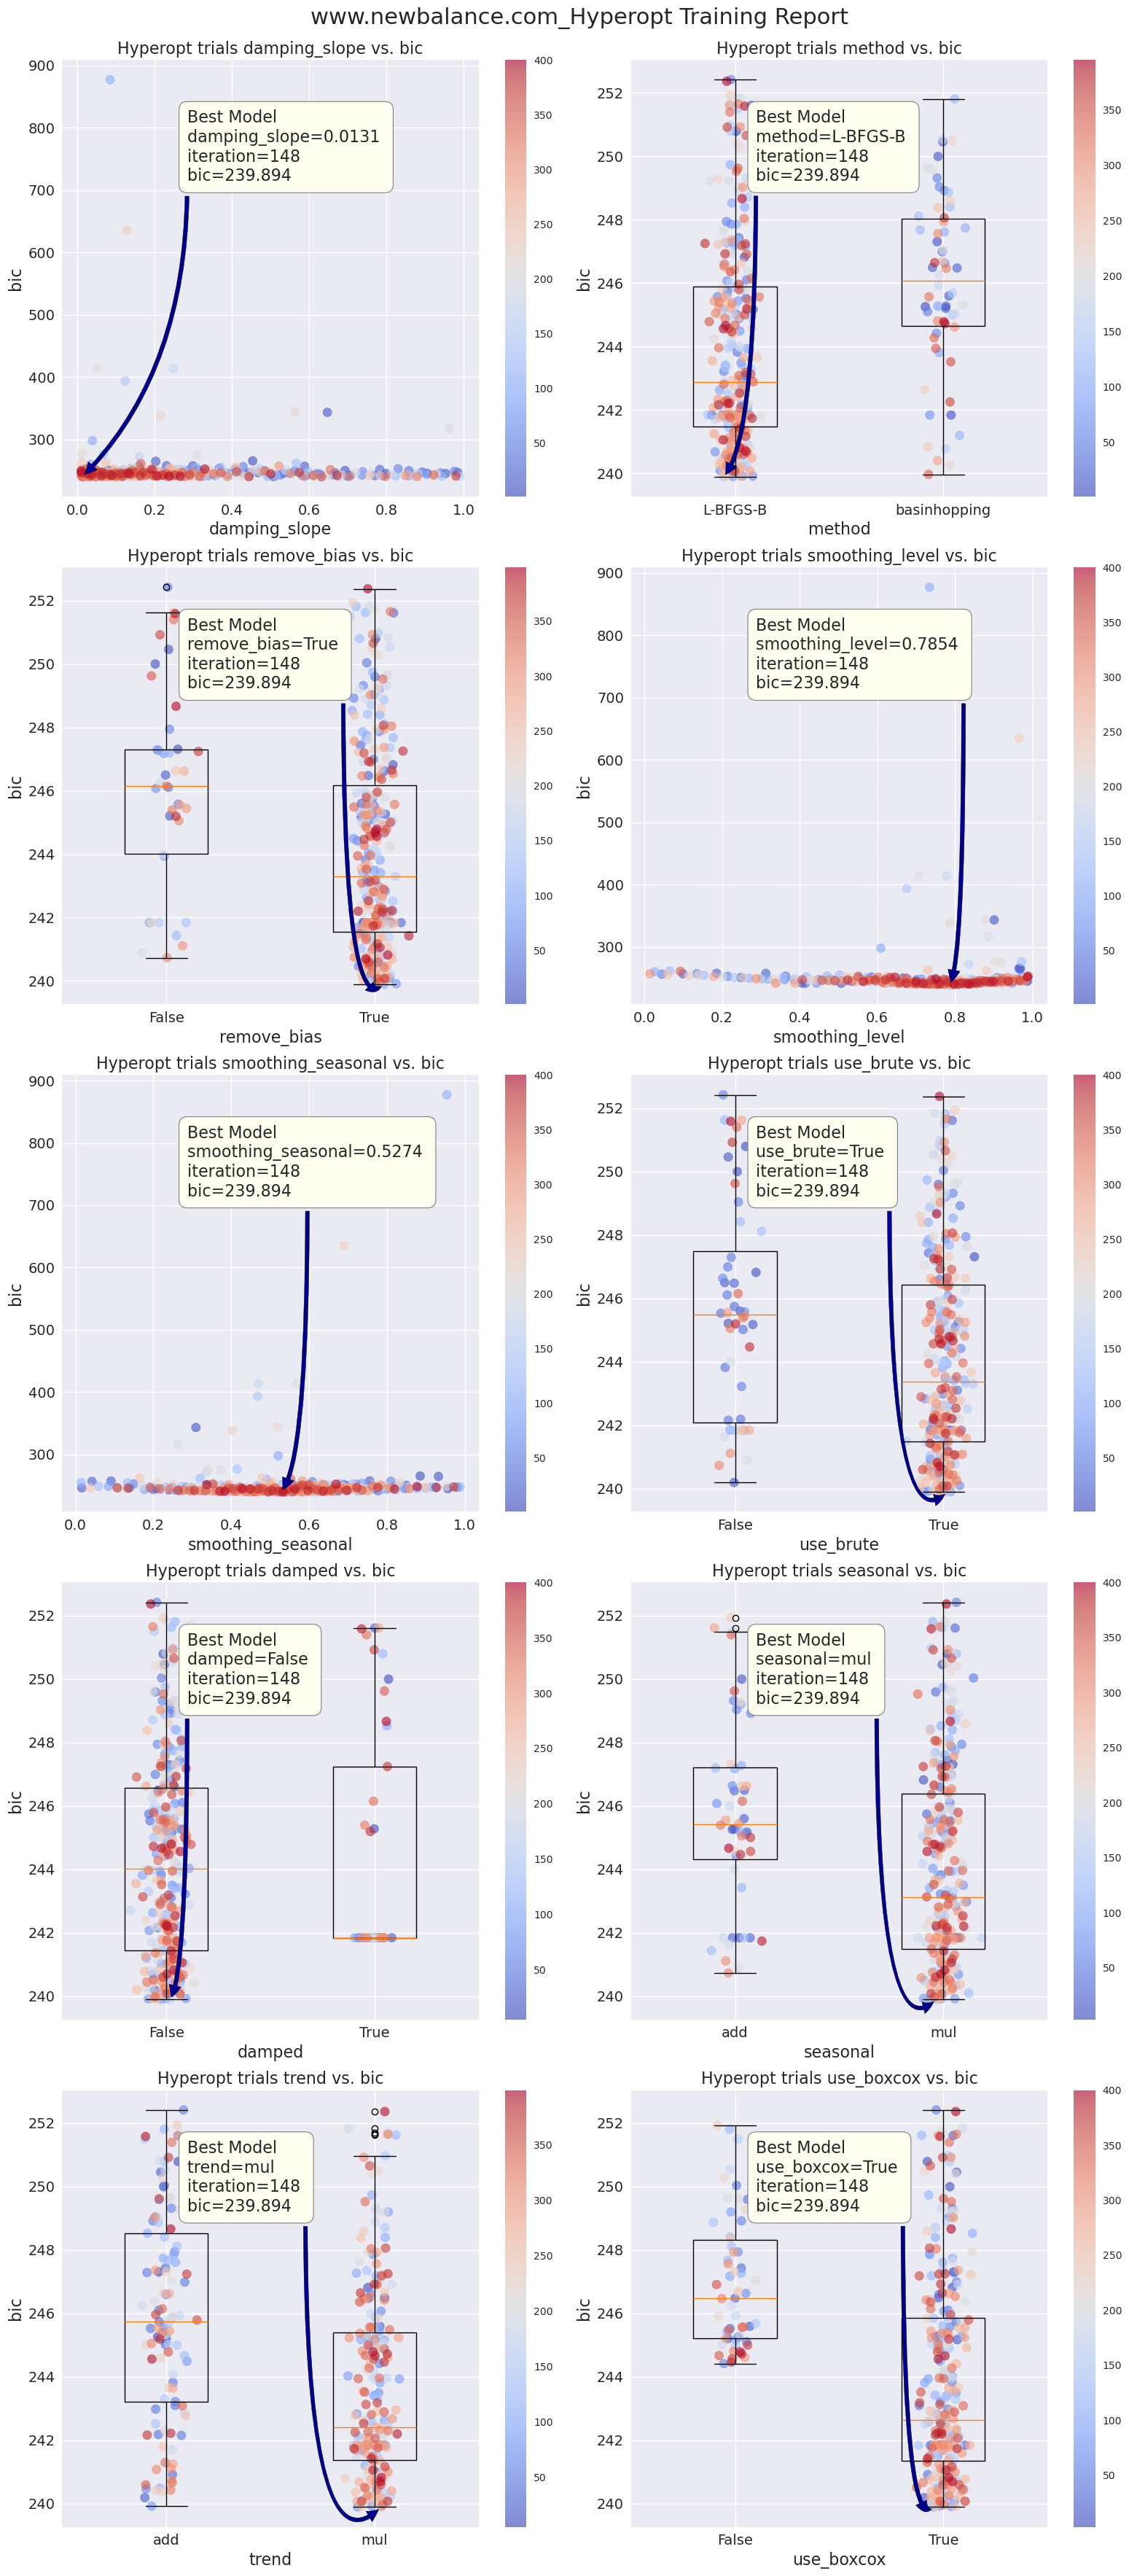

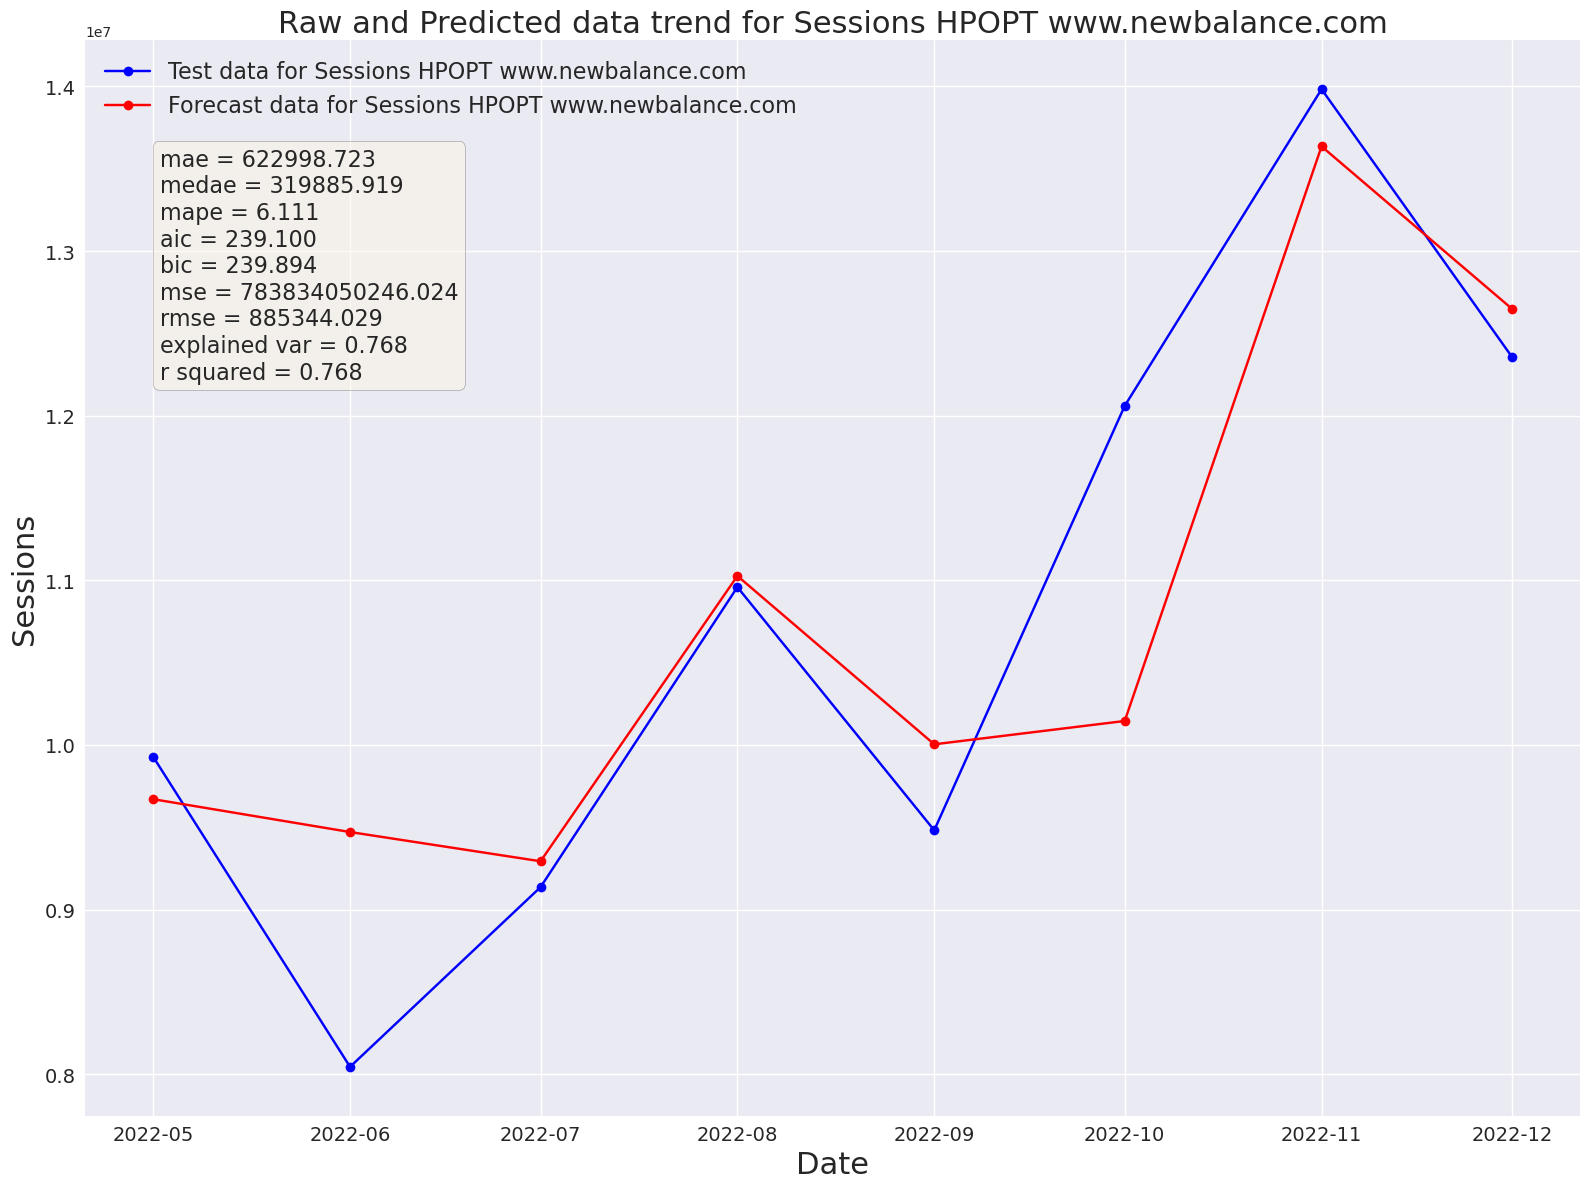

In [18]:
model_outputs[hostname] = run_tuning(train=train[all_model_config['forecast_field']], 
                                    test=test[all_model_config['forecast_field']], 
                                    **run_config)

In [ ]:
model_outputs[hostname]['hyperopt_trials_data']

## test functionality of generate_hyperopt_report

In [ ]:
params = [x for x in list(model_outputs[hostname]['hyperopt_trials_data']) if x not in [TID_COL, run_config['loss_metric']]]
COLS = 2
ROWS = int(math.ceil(len(run_config)/COLS))

In [ ]:
ROWS

In [ ]:
list(model_outputs[hostname]['hyperopt_trials_data'])

In [ ]:
TID_COL

In [ ]:
run_config['loss_metric']

In [ ]:
run_config['hyperopt_title']

In [ ]:
run_config['hyperopt_image_name']

In [ ]:
hpopt_df = model_outputs[hostname]['hyperopt_trials_data']
metric = run_config['loss_metric']

In [ ]:
with plt.style.context(style='seaborn-v0_8'):
    u_filter = hpopt_df[metric].quantile(0.9)
    grid = gs.GridSpec(ROWS, COLS)
    fig = plt.figure(figsize=(16, 36))

    column = 'seasonal_periods'
    unique_vals = sorted(hpopt_df[column].unique())
    ax = fig.add_subplot(grid[0])
    print(len(unique_vals))
    if len(unique_vals) > 6:
        x = hpopt_df[column]
        y = hpopt_df[metric]
        im = ax.scatter(x=x, y=y, c=hpopt_df[TID_COL], marker='o', s=80, cmap=plt.cm.coolwarm, alpha=0.6)
        fig.colorbar(im, ax=ax, orientation='vertical')
        annotate_num(x, y, hpopt_df[TID_COL], metric, column, ax)
    else:
        j = 0
        min_metric_row = hpopt_df[hpopt_df[metric] == hpopt_df[metric].min()]
        for i in unique_vals:
            y_interim = hpopt_df[hpopt_df[column] == i]
            y_pre_filter = y_interim[(y_interim[metric] < u_filter)]
            y = y_pre_filter[metric]
            ax.boxplot(y, positions=[j+1], widths=0.4)
            if isinstance(i, str):   
                x = np.random.normal(1+j, 0.05, size=len(y))
            else:
                print("running")
                x = np.random.normal(1+i, 0.05, size=len(y))
                print(x)
            sp = ax.scatter(x=x, y=y, c=y_pre_filter[TID_COL], marker='o', alpha=0.6, s=80, 
                            cmap=plt.cm.coolwarm)
            if min_metric_row[metric].values[0] in y_pre_filter[metric].values:
                annotate_str(x, y, min_metric_row, metric, column, ax)
            j+=1
        fig.colorbar(sp, ax=ax, orientation='vertical')
        ax.set_xticklabels(unique_vals)
    ax.set_title('Hyperopt trials {} vs. {}'.format(column, metric))
    ax.set_ylabel(metric)
    ax.set_xlabel(column)
    for i in (ax.get_xticklabels() + ax.get_yticklabels()):
        i.set_fontsize(SMALL_FONT)  
    for i in [ax.title, ax.xaxis.label, ax.yaxis.label]:
        i.set_fontsize(MED_FONT)
    fig.tight_layout()
    plt.show()

In [ ]:
with plt.style.context(style='seaborn-v0_8'):
    u_filter = hpopt_df[metric].quantile(0.9)
    grid = gs.GridSpec(ROWS, COLS)
    fig = plt.figure(figsize=(16, 36))

    column = 'damped'
    unique_vals = sorted(hpopt_df[column].unique())
    ax = fig.add_subplot(grid[0])
    print(len(unique_vals))
    if len(unique_vals) > 6:
        x = hpopt_df[column]
        y = hpopt_df[metric]
        im = ax.scatter(x=x, y=y, c=hpopt_df[TID_COL], marker='o', s=80, cmap=plt.cm.coolwarm, alpha=0.6)
        fig.colorbar(im, ax=ax, orientation='vertical')
        annotate_num(x, y, hpopt_df[TID_COL], metric, column, ax)
    else:
        j = 0
        min_metric_row = hpopt_df[hpopt_df[metric] == hpopt_df[metric].min()]
        for i in unique_vals:
            y_interim = hpopt_df[hpopt_df[column] == i]
            y_pre_filter = y_interim[(y_interim[metric] < u_filter)]
            y = y_pre_filter[metric]
            ax.boxplot(y, positions=[j+1], widths=0.4)
            if isinstance(i, str):   
                x = np.random.normal(1+j, 0.05, size=len(y))
            else:
                print("running")
                x = np.random.normal(1+i, 0.05, size=len(y))
                print(x)
            sp = ax.scatter(x=x, y=y, c=y_pre_filter[TID_COL], marker='o', alpha=0.6, s=80, 
                            cmap=plt.cm.coolwarm)
            if min_metric_row[metric].values[0] in y_pre_filter[metric].values:
                annotate_str(x, y, min_metric_row, metric, column, ax)
            j+=1
        fig.colorbar(sp, ax=ax, orientation='vertical')
        ax.set_xticklabels(unique_vals)
    ax.set_title('Hyperopt trials {} vs. {}'.format(column, metric))
    ax.set_ylabel(metric)
    ax.set_xlabel(column)
    for i in (ax.get_xticklabels() + ax.get_yticklabels()):
        i.set_fontsize(SMALL_FONT)  
    for i in [ax.title, ax.xaxis.label, ax.yaxis.label]:
        i.set_fontsize(MED_FONT)
    fig.tight_layout()
    plt.show()

## test functionality of run_tuning

In [ ]:
run_config

In [ ]:
run_config['tuning_space']['model']['seasonal_periods']

In [ ]:
model_outputs[hostname] = run_tuning(train=train[all_model_config['forecast_field']], 
                                    test=test[all_model_config['forecast_field']], 
                                    **run_config)

In [ ]:
model_outputs[hostname]

In [ ]:
"""
param_count = extract_param_count_hwes(params['tuning_space'])
output = {}
trial_run = Trials()
tuning = fmin(partial(params['minimization_function'], 
                      train=train, 
                      test=test,
                      loss_metric=params['loss_metric'],
                      progress=params['progress']
                     ), 
              params['tuning_space'], 
              algo=params['hpopt_algo'], 
              max_evals=params['iterations'], 
              trials=trial_run,
              verbose=params['verbose'],
              catch_eval_exceptions=True
             )
best_run = space_eval(params['tuning_space'], tuning)
generated_model = params['forecast_algo'](train, test, best_run)
extracted_trials = extract_hyperopt_trials(trial_run, params['tuning_space'], params['loss_metric'])
output['best_hp_params'] = best_run
output['best_model'] = generated_model['model']
output['hyperopt_trials_data'] = extracted_trials
output['hyperopt_trials_visualization'] = generate_hyperopt_report(extracted_trials, 
                                                                   params['loss_metric'], 
                                                                   params['hyperopt_title'], 
                                                                   params['hyperopt_image_name'])
output['forecast_data'] = generated_model['forecast']
output['series_prediction'] = build_future_forecast(generated_model['model'],
                                                    params['hostname_name'],
                                                    params['future_forecast_periods'],
                                                    params['train_split_cutoff_months'],
                                                    params['target_name']
                                                   )
output['plot_data'] = plot_predictions(test, 
                                       generated_model['forecast'], 
                                       param_count,
                                       params['name'], 
                                       params['target_name'], 
                                       params['image_name'])
"""

In [ ]:
param_count = extract_param_count_hwes(run_config['tuning_space'])

In [ ]:
param_count

In [ ]:
train

In [ ]:
output = {}
trial_run = Trials()
tuning = fmin(partial(run_config['minimization_function'], 
                      train=train, 
                      test=test,
                      loss_metric=run_config['loss_metric'],
                      progress=run_config['progress']
                     ), 
              run_config['tuning_space'], 
              algo=run_config['hpopt_algo'], 
              max_evals=run_config['iterations'], 
              trials=trial_run,
              verbose=True,
              # verbose=run_config['verbose'],
              catch_eval_exceptions=True
             )

In [ ]:
run_config['verbose']

In [ ]:
run_config['tuning_space']

In [ ]:
run_config['iterations']

In [ ]:
run_config['minimization_function']